In [2]:
# Load libraries
import casadi as ca
import numpy as np
import pandas as pd
import optuna
import sqlite3
from optuna.samplers import TPESampler

/home/sjbaek/miniforge3/envs/torchenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# EXP data
df_exp = pd.read_csv('reparameterization.csv')
df_exp

,PW,Fv,H2,CH4,C2H6,C2H4,C2H2,C3H8,C3H6,C4H10,C5H12,C
0,37.0,30,9.804,84.304,2.551,0.174,0.142,0.768,0.043,0.124,0.131,1.960
1,37.0,50,6.437,89.628,1.836,0.149,0.119,0.525,0.031,0.078,0.087,1.108
2,37.0,70,4.774,92.291,1.399,0.133,0.101,0.382,0.025,0.053,0.062,0.781
3,37.0,90,3.774,93.898,1.122,0.121,0.088,0.295,0.020,0.039,0.047,0.597
4,28.0,30,6.680,89.250,1.860,0.148,0.111,0.534,0.031,0.081,0.089,1.216
5,22.5,30,4.076,93.409,1.206,0.122,0.087,0.320,0.021,0.043,0.051,0.664


In [5]:
# Components
components = ['H2', 'CH4', 'C2H6', 'C2H4', 'C2H2', 'C3H8', 'C3H6', 'C4H10', 'C5H12', 'C']

In [6]:
def acq_func(k):
    # Reactor configuration
    L = 0.15 # m, length of the DBD plasma region
    D_rod = 0.003 # m, diameter of the rod
    D_in = 0.009 # m, inner diameter of the reactor
    A = np.pi*(D_in**2 - D_rod**2)/4 # m2, cross-sectional area of the reactor
    V = A*L # m3, volume of the DBD plasma region

    # Domain
    N = 31
    dx = L / (N - 1)

    # Ideal gas law
    def pDens_Mol_Vap(T, P):
        """
        Calculate the molar density of the gas phase
        """
        R = 0.08314472  # bar·m³/(kmol·K), gas constant

        return P/(R*(T+273.15)) # kmol/m3, molar density of the gas phase

    # z_out을 매 순환마다 구하고, 이를 z_out_df에 순차적으로 저장
    z_out_list = []  # outlet mole fractions 기록 리스트

    for i in range(len(df_exp)):
        # Operating conditions
        T = 25 # C, operating temperature
        P = 1.01325 # bar, operating pressure
        PW = df_exp['PW'][i]/(V*1e6) # W/mL, power density

        # Feed conditions
        Fv = df_exp['Fv'][i] # mL/min, feed volume flow rate
        Fv = Fv*1e-6/60 # m3/s, feed volume flow rate
        rhoF = pDens_Mol_Vap(T, P) # kmol/m3, molar density of the feed
        zF = {comp: 1 - 1e-6*9 if comp == 'CH4' else 1e-6 for comp in components}
        CF = {comp: zF[comp]*rhoF for comp in components}
        VF = Fv/A # m/s, feed superficial velocity

        # Thermodynamics
        C = {comp: ca.MX.sym(f'C_{comp}', N) for comp in components}

        rho = sum(C[comp] for comp in components)
        z = {comp: C[comp] / rho for comp in components}
        pP = {comp: P * z[comp] for comp in components}

        # Reaction
        # Reaction rate constants [kmol/s/bar^(order)/m3]
        k1f  = k[0] * 1e10    # 2CH4 -> C2H6 + H2
        k2f  = k[1] * 1e5     # C2H6 -> C2H4 + H2
        k3f  = k[2] * 1e10    # C2H4 + H2 -> C2H6
        k4f  = k[3] * 1e10    # 2CH4 -> C2H4 + 2H2
        k5f  = k[4] * 1e15    # C2H4 + 2H2 -> 2CH4
        k6f  = k[5] * 1e5      # C2H4 -> C2H2 + H2
        k7f  = k[6] * 1e10    # CH4 + C2H4 -> C3H8
        k8f  = k[7] * 1e5     # C3H8 -> C3H6
        k9f  = k[8] * 1e5     # C3H6 -> C2H4 + CH4
        k10f = k[9] * 1e15     # 2C2H4 + H2 -> C4H10
        k11f = k[10] * 1e10    # C3H8 + CH4 -> C4H10 + H2
        k12f = k[11] * 1e10    # C4H10 + CH4 -> C5H12 + H2
        k13f = k[12] * 1e5     # CH4 -> C + 2H2

        # Power exponents of reaction rates
        a1  = k[13]
        a2  = k[14]
        a3  = k[15]
        a4  = k[16]
        a5  = k[17]
        a6  = k[18]
        a7  = k[19]
        a8  = k[20]
        a9  = k[21]
        a10 = k[22]
        a11 = k[23]
        a12 = k[24]
        a13 = k[25]

        k1  = k1f  * PW**a1
        k2  = k2f  * PW**a2
        k3  = k3f  * PW**a3
        k4  = k4f  * PW**a4
        k5  = k5f  * PW**a5
        k6  = k6f  * PW**a6
        k7  = k7f  * PW**a7
        k8  = k8f  * PW**a8
        k9  = k9f  * PW**a9
        k10 = k10f * PW**a10
        k11 = k11f * PW**a11
        k12 = k12f * PW**a12
        k13 = k13f * PW**a13

        r1 = k1 * pP['CH4'] * pP['CH4']
        r2 = k2 * pP['C2H6']
        r3 = k3 * pP['C2H4'] * pP['H2']
        r4 = k4 * pP['CH4'] * pP['CH4']
        r5 = k5 * pP['C2H4'] * pP['C2H4'] * pP['H2'] * pP['H2']
        r6 = k6 * pP['C2H4']
        r7 = k7 * pP['CH4'] * pP['C2H4']
        r8 = k8 * pP['C3H8']
        r9 = k9 * pP['C3H6']
        r10 = k10 * pP['C2H4'] * pP['C2H4'] * pP['H2']
        r11 = k11 * pP['C3H8'] * pP['CH4']
        r12 = k12 * pP['C4H10'] * pP['CH4']
        r13 = k13 * pP['CH4']

        # Mass balance
        Vx = ca.MX.sym('Vx', N)

        res = []
        for j in range(N):
            if j == 0:
                # Dirichlet B.C. at inlet:
                res.append(Vx[j] - VF)
                for comp in components:
                    res.append(C[comp][j] - CF[comp])
            elif j == N-1:
                # Neumann B.C. at outlet:
                res.append((Vx[j] - Vx[j-1])/dx)
                for comp in components:
                    res.append((C[comp][j] - C[comp][j-1])/dx)
            else:
                # Interior nodes:
                res.append(-rho[j]*((Vx[j] - Vx[j-1])/dx) + (r2[j] - r3[j] + r4[j] - r5[j] + r6[j] - r7[j] + r8[j] + r9[j] - 2*r10[j] + 2*r13[j]))
                res.append(-Vx[j]*((C['H2'][j] - C['H2'][j-1])/dx) - C['H2'][j]*((Vx[j] - Vx[j-1])/dx) + (r1[j] + r2[j] - r3[j] + 2*r4[j] - 2*r5[j] + r6[j] + r8[j] - r10[j] + r11[j] + r12[j] + 2*r13[j]))
                res.append(-Vx[j]*((C['CH4'][j] - C['CH4'][j-1])/dx) - C['CH4'][j]*((Vx[j] - Vx[j-1])/dx) + (-2*r1[j] - 2*r4[j] + 2*r5[j] - r7[j] + r9[j] - r11[j] - r12[j] - r13[j]))
                res.append(-Vx[j]*((C['C2H6'][j] - C['C2H6'][j-1])/dx) - C['C2H6'][j]*((Vx[j] - Vx[j-1])/dx) + (r1[j] - r2[j] + r3[j]))
                res.append(-Vx[j]*((C['C2H4'][j] - C['C2H4'][j-1])/dx) - C['C2H4'][j]*((Vx[j] - Vx[j-1])/dx) + (r2[j] - r3[j] + r4[j] - r5[j] - r6[j] - r7[j] - 2*r10[j]))
                res.append(-Vx[j]*((C['C2H2'][j] - C['C2H2'][j-1])/dx) - C['C2H2'][j]*((Vx[j] - Vx[j-1])/dx) + (r6[j] + r9[j]))
                res.append(-Vx[j]*((C['C3H8'][j] - C['C3H8'][j-1])/dx) - C['C3H8'][j]*((Vx[j] - Vx[j-1])/dx) + (r7[j] - r8[j] - r11[j]))
                res.append(-Vx[j]*((C['C3H6'][j] - C['C3H6'][j-1])/dx) - C['C3H6'][j]*((Vx[j] - Vx[j-1])/dx) + (r8[j] - r9[j]))
                res.append(-Vx[j]*((C['C4H10'][j] - C['C4H10'][j-1])/dx) - C['C4H10'][j]*((Vx[j] - Vx[j-1])/dx) + (r10[j] + r11[j] - r12[j]))
                res.append(-Vx[j]*((C['C5H12'][j] - C['C5H12'][j-1])/dx) - C['C5H12'][j]*((Vx[j] - Vx[j-1])/dx) + (r12[j]))
                res.append(-Vx[j]*((C['C'][j] - C['C'][j-1])/dx) - C['C'][j]*((Vx[j] - Vx[j-1])/dx) + (r13[j]))
        residuals = ca.vertcat(*res)

        # Decision variables: Vx and C
        x = ca.vertcat(Vx, *[C[comp] for comp in components])

        # Compute Jacobian: dg/dx
        constraints = ca.vertcat(*res)
        jacobian = ca.jacobian(constraints, x)

        # Objective function (minimize residual)
        objective = sum([res_i**2 for res_i in res])

        # NLP problem
        nlp = {
            'x': x,
            'f': objective,
            'g': constraints
        }

        # Solver options
        opts = {
            'ipopt.print_level': 0,  # suppress solver output
            'ipopt.max_iter': 1000,
            'print_time': 0
        }

        # Create solver
        solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

        # Initial guess: Vx = VF, C = CF
        x0 = [VF] * N  # Vx initial guess
        for comp in components:
            x0.extend([CF[comp]] * N)

        # Bounds on decision variables
        # Vx: positive velocity
        lbx = [0] * N
        ubx = [ca.inf] * N
        # C: positive concentrations
        for comp in components:
            lbx.extend([0] * N)
            ubx.extend([ca.inf] * N)

        # Bounds on constraints (equality: g = 0)
        lbg = [0] * len(res)
        ubg = [0] * len(res)

        # Solve
        sol = solver(x0=x0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)

        # Print solver success and objective value
        success = bool(solver.stats()['success']) if 'success' in solver.stats() else (solver.stats()['return_status'] in ['Solve_Succeeded', 'Search_Direction_Becomes_Too_Small'])

        # Extract solution vector from solver output
        x_sol = sol['x'].full().flatten()

        # Extract concentrations of each component at every position
        C_sol = {}
        idx = N
        for comp in components:
            C_sol[comp] = x_sol[idx:idx+N]
            idx += N

        # Compute total concentration at each position
        rho_sol = [sum(C_sol[comp][j] for comp in components) for j in range(N)]

        # Compute mole fractions z_sol as a dictionary of arrays (one per component)
        z_sol = {comp: [C_sol[comp][j]/rho_sol[j] if rho_sol[j] != 0 else 0.0 for j in range(N)] for comp in components}

        # Extract only outlet mole fractions (i.e., at N-1) and treat each component as a column
        z_out = {comp: z_sol[comp][-1] for comp in components}

        # outlet 결과 리스트에 저장
        z_out_list.append(z_out)

    # 모든 순환의 결과를 DataFrame으로 변환
    z_out_df = pd.DataFrame(z_out_list, columns=components)
    component_cols = z_out_df.columns
    exp_vals = df_exp[component_cols]
    mse_dict = {}
    for col in component_cols:
        mse = ((z_out_df[col]*100 - exp_vals[col]) ** 2).mean()
        mse_dict[col] = mse
    mean_mse = sum(mse_dict.values()) / len(mse_dict)
    return mean_mse

In [7]:
def obj_func(trial):
    x0 = np.array([
    6.21651338949252E-16,   # k1f (before scaling)
    1.45381304292678E-09,   # k2f (before scaling)
    1.02809258261384E-15,   # k3f (before scaling)
    6.69290771731354E-16,   # k4f (before scaling)
    2.85019436220242E-16,   # k5f (before scaling)
    9.2297699519191E-09,    # k6f (before scaling)
    6.40249201636818E-13,   # k7f (before scaling)
    8.37829309499448E-10,   # k8f (before scaling)
    1.00236478134064E-15,   # k9f (before scaling)
    3.1507112154179E-15,    # k10f (before scaling)
    1.28826018471033E-14,   # k11f (before scaling)
    3.89614664854626E-14,   # k12f (before scaling)
    2.89923516688058E-11,   # k13f (before scaling)
    1.908440317,             # a1
    1.240031702,             # a2
    1.01308532,              # a3
    1.040422716,             # a4
    0.175496697,             # a5
    0.928206422,             # a6
    0.876775871,             # a7
    1.109250254,             # a8
    0.999630013,             # a9
    0.172927302,             # a10
    2.051971156,             # a11
    2.27283981,              # a12
    1.993678731,              # a13
])
    k = [trial.suggest_float(f'k{i}', 0.8, 1.2) for i in range(26)]
    mean_mse = acq_func(k*x0)
    return mean_mse

In [19]:
study_name = 'DBD_Plasma_kinetic_model'
study = optuna.create_study(
    study_name=study_name,
    direction='minimize',
    sampler=TPESampler(n_startup_trials=10),
    storage='sqlite:///' + study_name + '.db',
    load_if_exists=True
)
study.optimize(obj_func, n_trials=1000)


[I 2025-11-03 17:28:48,515] A new study created in RDB with name: DBD_Plasma_kinetic_model
[I 2025-11-03 17:28:58,749] Trial 0 finished with value: 0.161379496392146 and parameters: {'k0': 1.0645904349747695, 'k1': 1.0246532263864045, 'k2': 0.9407764441603637, 'k3': 1.0150265512502274, 'k4': 1.0279752305585832, 'k5': 1.1656382263091907, 'k6': 0.933988576849566, 'k7': 0.9662596376493686, 'k8': 0.8375174903233553, 'k9': 1.0830979784942785, 'k10': 1.195494910745759, 'k11': 0.8404825923621986, 'k12': 1.0201975273595527, 'k13': 0.808429305225447, 'k14': 0.9253238046068759, 'k15': 1.1568101415436798, 'k16': 1.1683085415045653, 'k17': 0.8722447298145658, 'k18': 1.008667609928871, 'k19': 0.9194941338862664, 'k20': 0.8886831003629664, 'k21': 1.0332133766335907, 'k22': 1.153107424791729, 'k23': 1.0878791312240113, 'k24': 0.8747594327949446, 'k25': 1.0952763085140282}. Best is trial 0 with value: 0.161379496392146.
[I 2025-11-03 17:29:08,151] Trial 1 finished with value: 0.2236596155888216 and pa

In [ ]:
# DB에서 best parameter 및 x0 결과를 실험 데이터와 비교
import matplotlib.pyplot as plt

# 1. Best parameter 및 x0 준비
study_name = 'DBD_Plasma_kinetic_model'
storage_url = f'sqlite:///{study_name}.db'
study = optuna.load_study(study_name=study_name, storage=storage_url)

best_k = np.array([study.best_trial.params[f'k{i}'] for i in range(26)])
x0 = np.array([
    6.21651338949252E-16,   # k1f
    1.45381304292678E-09,   # k2f
    1.02809258261384E-15,   # k3f
    6.69290771731354E-16,   # k4f
    2.85019436220242E-16,   # k5f
    9.2297699519191E-09,    # k6f
    6.40249201636818E-13,   # k7f
    8.37829309499448E-10,   # k8f
    1.00236478134064E-15,   # k9f
    3.1507112154179E-15,    # k10f
    1.28826018471033E-14,   # k11f
    3.89614664854626E-14,   # k12f
    2.89923516688058E-11,   # k13f
    1.908440317,             # a1
    1.240031702,             # a2
    1.01308532,              # a3
    1.040422716,             # a4
    0.175496697,             # a5
    0.928206422,             # a6
    0.876775871,             # a7
    1.109250254,             # a8
    0.999630013,             # a9
    0.172927302,             # a10
    2.051971156,             # a11
    2.27283981,              # a12
    1.993678731,             # a13
])
best_param = best_k * x0

print(f"Best Trial Number: {study.best_trial.number}")
print(f"Best MSE Value: {study.best_trial.value:.6f}")

# 2. 모델 예측 함수 정의
def calculate_predictions(param):
    """주어진 파라미터로 모든 실험 조건에서 모델 예측값 계산"""
    L = 0.15
    D_rod = 0.003
    D_in = 0.009
    A = np.pi*(D_in**2 - D_rod**2)/4
    V = A*L
    N = 31
    dx = L / (N - 1)

    def pDens_Mol_Vap(T, P):
        R = 0.08314472
        return P/(R*(T+273.15))

    z_list = []

    for i in range(len(df_exp)):
        T = 25
        P = 1.01325
        PW = df_exp['PW'][i]/(V*1e6)
        Fv = df_exp['Fv'][i] * 1e-6/60
        rhoF = pDens_Mol_Vap(T, P)
        zF = {comp: 1 - 1e-6*9 if comp == 'CH4' else 1e-6 for comp in components}
        CF = {comp: zF[comp]*rhoF for comp in components}
        VF = Fv/A

        C = {comp: ca.MX.sym(f'C_{comp}', N) for comp in components}
        rho = sum(C[comp] for comp in components)
        z = {comp: C[comp] / rho for comp in components}
        pP = {comp: P * z[comp] for comp in components}

        # Reaction rate constants
        k1f  = param[0] * 1e10
        k2f  = param[1] * 1e5
        k3f  = param[2] * 1e10
        k4f  = param[3] * 1e10
        k5f  = param[4] * 1e15
        k6f  = param[5] * 1e5
        k7f  = param[6] * 1e10
        k8f  = param[7] * 1e5
        k9f  = param[8] * 1e5
        k10f = param[9] * 1e15
        k11f = param[10] * 1e10
        k12f = param[11] * 1e10
        k13f = param[12] * 1e5

        a1  = param[13]
        a2  = param[14]
        a3  = param[15]
        a4  = param[16]
        a5  = param[17]
        a6  = param[18]
        a7  = param[19]
        a8  = param[20]
        a9  = param[21]
        a10 = param[22]
        a11 = param[23]
        a12 = param[24]
        a13 = param[25]

        k1  = k1f  * PW**a1
        k2  = k2f  * PW**a2
        k3  = k3f  * PW**a3
        k4  = k4f  * PW**a4
        k5  = k5f  * PW**a5
        k6  = k6f  * PW**a6
        k7  = k7f  * PW**a7
        k8  = k8f  * PW**a8
        k9  = k9f  * PW**a9
        k10 = k10f * PW**a10
        k11 = k11f * PW**a11
        k12 = k12f * PW**a12
        k13 = k13f * PW**a13

        r1 = k1 * pP['CH4'] * pP['CH4']
        r2 = k2 * pP['C2H6']
        r3 = k3 * pP['C2H4'] * pP['H2']
        r4 = k4 * pP['CH4'] * pP['CH4']
        r5 = k5 * pP['C2H4'] * pP['C2H4'] * pP['H2'] * pP['H2']
        r6 = k6 * pP['C2H4']
        r7 = k7 * pP['CH4'] * pP['C2H4']
        r8 = k8 * pP['C3H8']
        r9 = k9 * pP['C3H6']
        r10 = k10 * pP['C2H4'] * pP['C2H4'] * pP['H2']
        r11 = k11 * pP['C3H8'] * pP['CH4']
        r12 = k12 * pP['C4H10'] * pP['CH4']
        r13 = k13 * pP['CH4']

        Vx = ca.MX.sym('Vx', N)
        res = []
        
        for j in range(N):
            if j == 0:
                res.append(Vx[j] - VF)
                for comp in components:
                    res.append(C[comp][j] - CF[comp])
            elif j == N-1:
                res.append((Vx[j] - Vx[j-1])/dx)
                for comp in components:
                    res.append((C[comp][j] - C[comp][j-1])/dx)
            else:
                res.append(-rho[j]*((Vx[j] - Vx[j-1])/dx) + (r2[j] - r3[j] + r4[j] - r5[j] + r6[j] - r7[j] + r8[j] + r9[j] - 2*r10[j] + 2*r13[j]))
                res.append(-Vx[j]*((C['H2'][j] - C['H2'][j-1])/dx) - C['H2'][j]*((Vx[j] - Vx[j-1])/dx) + (r1[j] + r2[j] - r3[j] + 2*r4[j] - 2*r5[j] + r6[j] + r8[j] - r10[j] + r11[j] + r12[j] + 2*r13[j]))
                res.append(-Vx[j]*((C['CH4'][j] - C['CH4'][j-1])/dx) - C['CH4'][j]*((Vx[j] - Vx[j-1])/dx) + (-2*r1[j] - 2*r4[j] + 2*r5[j] - r7[j] + r9[j] - r11[j] - r12[j] - r13[j]))
                res.append(-Vx[j]*((C['C2H6'][j] - C['C2H6'][j-1])/dx) - C['C2H6'][j]*((Vx[j] - Vx[j-1])/dx) + (r1[j] - r2[j] + r3[j]))
                res.append(-Vx[j]*((C['C2H4'][j] - C['C2H4'][j-1])/dx) - C['C2H4'][j]*((Vx[j] - Vx[j-1])/dx) + (r2[j] - r3[j] + r4[j] - r5[j] - r6[j] - r7[j] - 2*r10[j]))
                res.append(-Vx[j]*((C['C2H2'][j] - C['C2H2'][j-1])/dx) - C['C2H2'][j]*((Vx[j] - Vx[j-1])/dx) + (r6[j] + r9[j]))
                res.append(-Vx[j]*((C['C3H8'][j] - C['C3H8'][j-1])/dx) - C['C3H8'][j]*((Vx[j] - Vx[j-1])/dx) + (r7[j] - r8[j] - r11[j]))
                res.append(-Vx[j]*((C['C3H6'][j] - C['C3H6'][j-1])/dx) - C['C3H6'][j]*((Vx[j] - Vx[j-1])/dx) + (r8[j] - r9[j]))
                res.append(-Vx[j]*((C['C4H10'][j] - C['C4H10'][j-1])/dx) - C['C4H10'][j]*((Vx[j] - Vx[j-1])/dx) + (r10[j] + r11[j] - r12[j]))
                res.append(-Vx[j]*((C['C5H12'][j] - C['C5H12'][j-1])/dx) - C['C5H12'][j]*((Vx[j] - Vx[j-1])/dx) + (r12[j]))
                res.append(-Vx[j]*((C['C'][j] - C['C'][j-1])/dx) - C['C'][j]*((Vx[j] - Vx[j-1])/dx) + (r13[j]))

        x = ca.vertcat(Vx, *[C[comp] for comp in components])
        constraints = ca.vertcat(*res)
        objective = sum([res_i**2 for res_i in res])

        nlp = {'x': x, 'f': objective, 'g': constraints}
        opts = {'ipopt.print_level': 0, 'ipopt.max_iter': 1000, 'print_time': 0}
        solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

        x_init = [VF] * N
        for comp in components:
            x_init.extend([CF[comp]] * N)

        lbx = [0] * N
        ubx = [ca.inf] * N
        for comp in components:
            lbx.extend([0] * N)
            ubx.extend([ca.inf] * N)

        lbg = [0] * len(res)
        ubg = [0] * len(res)

        sol = solver(x0=x_init, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)
        x_sol = sol['x'].full().flatten()

        C_sol = {}
        idx = N
        for comp in components:
            C_sol[comp] = x_sol[idx:idx+N]
            idx += N

        rho_sol = [sum(C_sol[comp][j] for comp in components) for j in range(N)]
        z_sol = {comp: [C_sol[comp][j]/rho_sol[j] if rho_sol[j] != 0 else 0.0 for j in range(N)] for comp in components}
        z_out = {comp: z_sol[comp][-1]*100 for comp in components}
        z_list.append(z_out)

    return pd.DataFrame(z_list, columns=components)

# 3. x0와 best_param 둘 다 계산
print("\n계산 중... x0 파라미터 모델 예측")
z_x0_df = calculate_predictions(x0)

print("계산 중... Best 파라미터 모델 예측")
z_best_df = calculate_predictions(best_param)

z_exp_df = df_exp[components].copy()

# 4. 비교 DataFrame 생성
print("\n" + "="*100)
print("실험 데이터 vs x0 vs Best Parameter 모델 예측 비교")
print("="*100)

compare_df = pd.DataFrame()
for comp in components:
    compare_df[f'{comp}_exp'] = z_exp_df[comp]
    compare_df[f'{comp}_x0'] = z_x0_df[comp]
    compare_df[f'{comp}_best'] = z_best_df[comp]

display(compare_df)

# 5. 통계 요약
print("\n통계 요약 (각 성분별):")
stats_df = pd.DataFrame()
for comp in components:
    mae_x0 = np.abs(z_x0_df[comp] - z_exp_df[comp]).mean()
    mae_best = np.abs(z_best_df[comp] - z_exp_df[comp]).mean()
    rmse_x0 = np.sqrt(((z_x0_df[comp] - z_exp_df[comp])**2).mean())
    rmse_best = np.sqrt(((z_best_df[comp] - z_exp_df[comp])**2).mean())
    stats_df[comp] = [mae_x0, mae_best, rmse_x0, rmse_best]
stats_df.index = ['MAE_x0', 'MAE_Best', 'RMSE_x0', 'RMSE_Best']
display(stats_df)

# 전체 MSE 비교
mse_x0 = ((z_x0_df.values - z_exp_df.values)**2).mean()
mse_best = ((z_best_df.values - z_exp_df.values)**2).mean()
print(f"\n전체 MSE - x0: {mse_x0:.6f}")
print(f"전체 MSE - Best: {mse_best:.6f}")
print(f"개선율: {(1 - mse_best/mse_x0)*100:.2f}%")

# 6. 시각화: x0 vs Best 비교
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, comp in enumerate(components):
    ax = axes[idx]
    
    # x0 결과
    ax.scatter(z_exp_df[comp], z_x0_df[comp], alpha=0.5, s=60, 
               c='blue', marker='o', label='x0', edgecolor='black', linewidth=0.5)
    
    # Best 결과
    ax.scatter(z_exp_df[comp], z_best_df[comp], alpha=0.5, s=60, 
               c='red', marker='s', label='Best', edgecolor='black', linewidth=0.5)
    
    # 대각선 (완벽한 예측)
    min_val = min(z_exp_df[comp].min(), z_x0_df[comp].min(), z_best_df[comp].min())
    max_val = max(z_exp_df[comp].max(), z_x0_df[comp].max(), z_best_df[comp].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, alpha=0.7, label='Perfect')
    
    ax.set_xlabel('Experimental (%)', fontsize=10)
    ax.set_ylabel('Predicted (%)', fontsize=10)
    ax.set_title(f'{comp}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.suptitle('x0 vs Best Parameter: 실험값 vs 예측값 비교', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# 7. 성분별 MAE 비교 막대그래프
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
x_pos = np.arange(len(components))
width = 0.35

mae_x0_values = [np.abs(z_x0_df[comp] - z_exp_df[comp]).mean() for comp in components]
mae_best_values = [np.abs(z_best_df[comp] - z_exp_df[comp]).mean() for comp in components]

bars1 = ax.bar(x_pos - width/2, mae_x0_values, width, alpha=0.7, color='blue', 
               edgecolor='black', label='x0')
bars2 = ax.bar(x_pos + width/2, mae_best_values, width, alpha=0.7, color='red', 
               edgecolor='black', label='Best')

ax.set_xlabel('Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
ax.set_title('x0 vs Best Parameter: 성분별 MAE 비교', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(components, fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n비교 완료!")


Best Trial Number: 854
Best MSE Value: 0.024979

계산 중... x0 파라미터 모델 예측
계산 중... Best 파라미터 모델 예측

실험 데이터 vs x0 vs Best Parameter 모델 예측 비교


,H2_exp,H2_x0,H2_best,CH4_exp,CH4_x0,CH4_best,C2H6_exp,C2H6_x0,C2H6_best,C2H4_exp,...,C3H6_best,C4H10_exp,C4H10_x0,C4H10_best,C5H12_exp,C5H12_x0,C5H12_best,C_exp,C_x0,C_best
0,9.804,10.641824,10.097545,84.304,83.080091,83.854934,2.551,2.788668,2.608071,0.174,...,0.093673,0.124,0.143437,0.101062,0.131,0.234968,0.102729,1.960,1.926373,2.001045
1,6.437,6.535657,6.263267,89.628,89.374594,89.810530,1.836,1.974645,1.829080,0.149,...,0.032371,0.078,0.071921,0.045410,0.087,0.067535,0.026901,1.108,1.221470,1.267658
2,4.774,4.710804,4.537173,92.291,92.260335,92.558905,1.399,1.516269,1.398906,0.133,...,0.015284,0.053,0.041254,0.024400,0.062,0.026757,0.010138,0.781,0.893971,0.927460
3,3.774,3.682226,3.556445,93.898,93.913536,94.140065,1.122,1.228125,1.130609,0.121,...,0.008517,0.039,0.025847,0.014643,0.047,0.012769,0.004712,0.597,0.704906,0.731189
4,6.680,6.809079,6.395699,89.250,89.050341,89.701540,1.860,1.889624,1.717994,0.148,...,0.048266,0.081,0.094411,0.060568,0.089,0.079435,0.034847,1.216,1.166532,1.203779
5,4.076,4.784052,4.439412,93.409,92.270083,92.834333,1.206,1.344198,1.196033,0.122,...,0.028071,0.043,0.060823,0.037497,0.051,0.030270,0.013727,0.664,0.775430,0.795702



통계 요약 (각 성분별):


,H2,CH4,C2H6,C2H4,C2H2,C3H8,C3H6,C4H10,C5H12,C
MAE_x0,0.321430,0.477015,0.127921,0.008998,0.029174,0.069794,0.010890,0.013608,0.037200,0.088145
MAE_Best,0.261562,0.361295,0.037444,0.008775,0.028894,0.063220,0.016263,0.022403,0.045658,0.104213
RMSE_x0,0.454990,0.695263,0.141833,0.010037,0.033744,0.083227,0.012568,0.014278,0.048517,0.094230
RMSE_Best,0.268534,0.387185,0.062775,0.010210,0.036262,0.071292,0.022891,0.023970,0.046924,0.118411



전체 MSE - x0: 0.073028
전체 MSE - Best: 0.024979
개선율: 65.80%


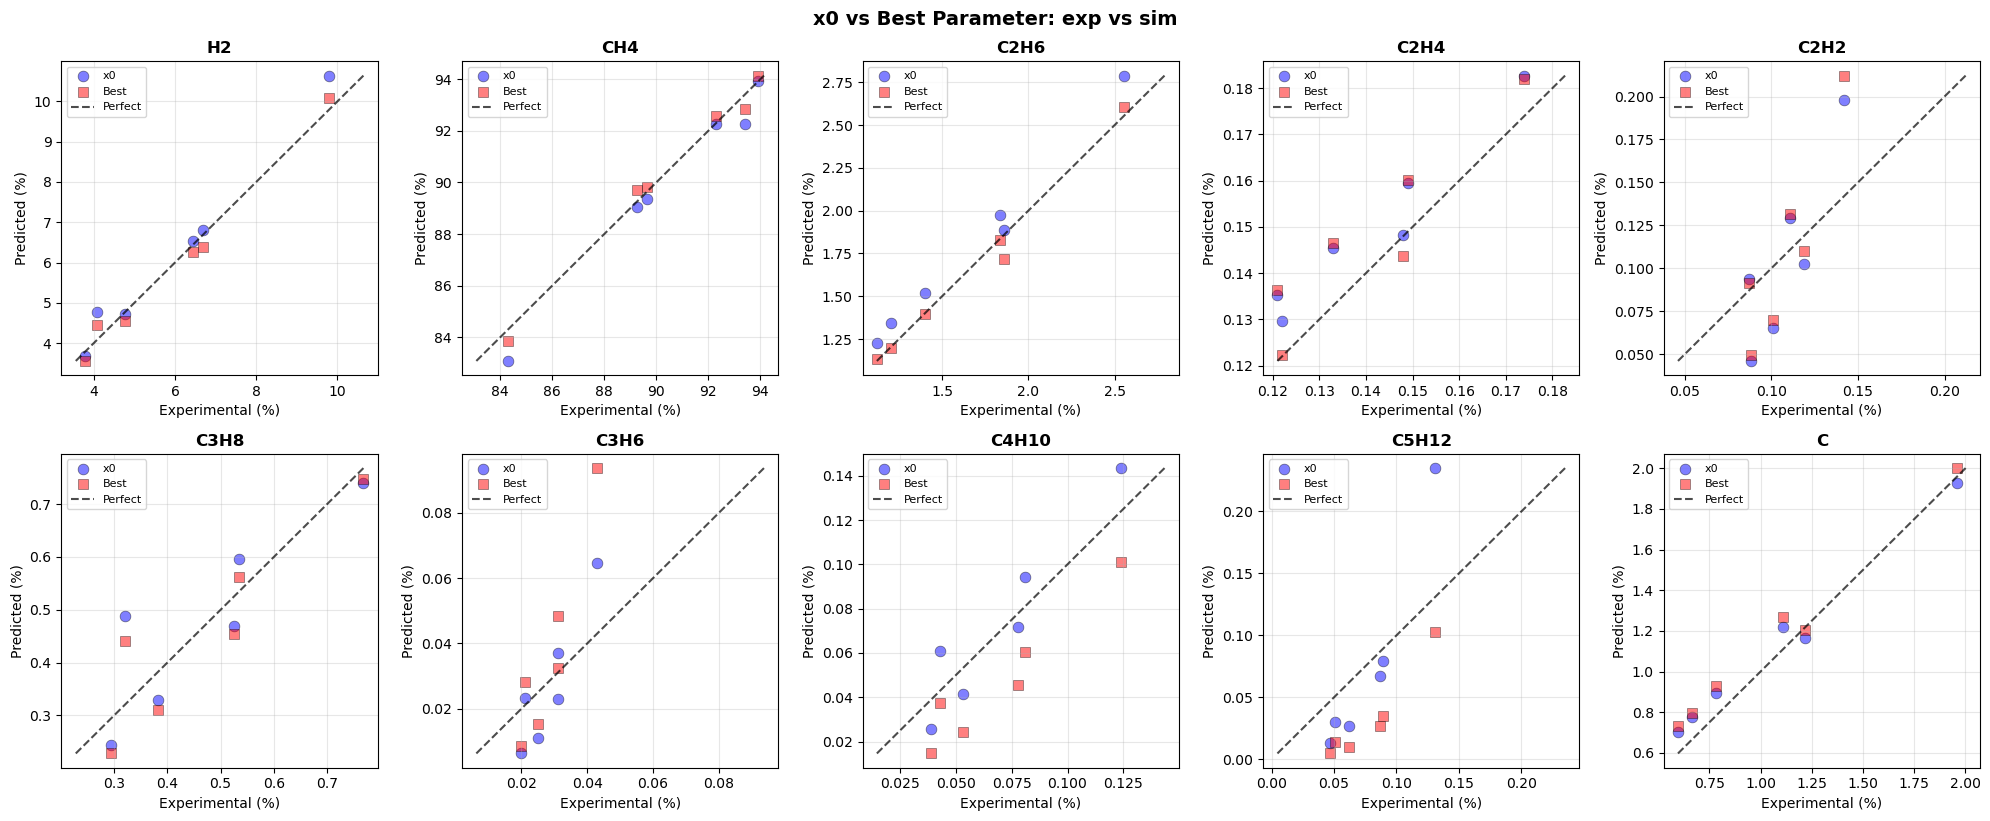

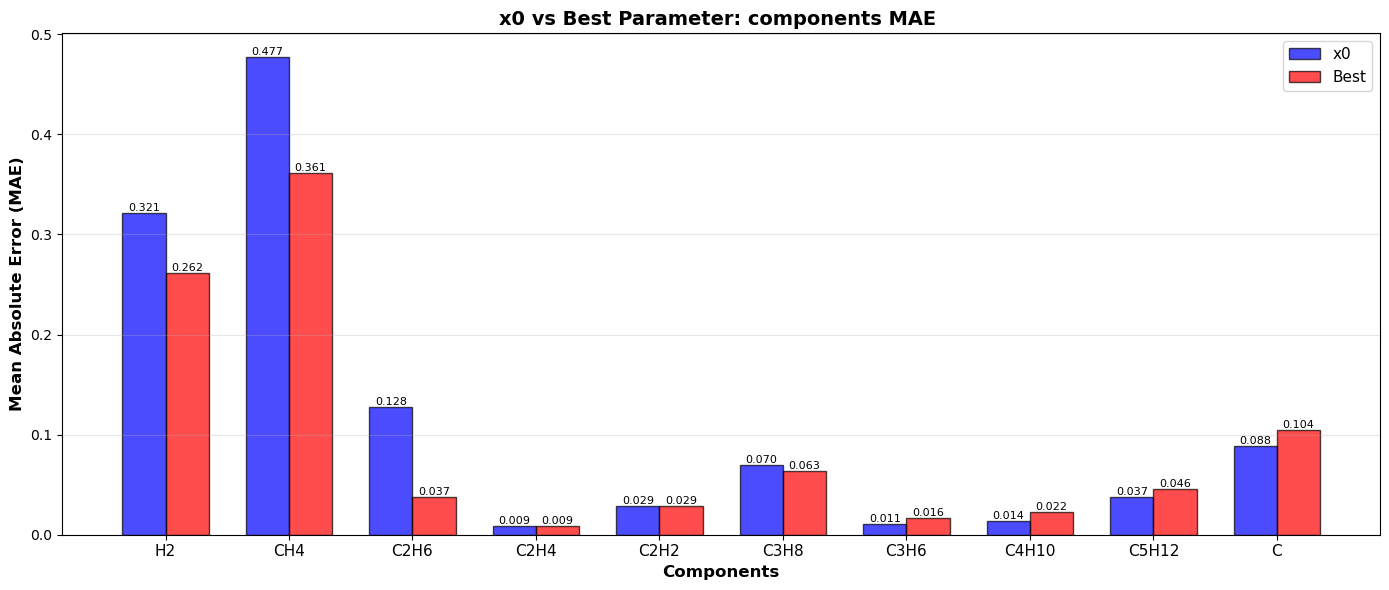


비교 완료!


In [9]:
# DB에서 best parameter 및 x0 결과를 실험 데이터와 비교
import matplotlib.pyplot as plt

# 1. Best parameter 및 x0 준비
study_name = 'DBD_Plasma_kinetic_model'
storage_url = f'sqlite:///{study_name}.db'
study = optuna.load_study(study_name=study_name, storage=storage_url)

best_k = np.array([study.best_trial.params[f'k{i}'] for i in range(26)])
x0 = np.array([
    6.21651338949252E-16,   # k1f
    1.45381304292678E-09,   # k2f
    1.02809258261384E-15,   # k3f
    6.69290771731354E-16,   # k4f
    2.85019436220242E-16,   # k5f
    9.2297699519191E-09,    # k6f
    6.40249201636818E-13,   # k7f
    8.37829309499448E-10,   # k8f
    1.00236478134064E-15,   # k9f
    3.1507112154179E-15,    # k10f
    1.28826018471033E-14,   # k11f
    3.89614664854626E-14,   # k12f
    2.89923516688058E-11,   # k13f
    1.908440317,             # a1
    1.240031702,             # a2
    1.01308532,              # a3
    1.040422716,             # a4
    0.175496697,             # a5
    0.928206422,             # a6
    0.876775871,             # a7
    1.109250254,             # a8
    0.999630013,             # a9
    0.172927302,             # a10
    2.051971156,             # a11
    2.27283981,              # a12
    1.993678731,             # a13
])
best_param = best_k * x0

print(f"Best Trial Number: {study.best_trial.number}")
print(f"Best MSE Value: {study.best_trial.value:.6f}")

# 2. 모델 예측 함수 정의
def calculate_predictions(param):
    """주어진 파라미터로 모든 실험 조건에서 모델 예측값 계산"""
    L = 0.15
    D_rod = 0.003
    D_in = 0.009
    A = np.pi*(D_in**2 - D_rod**2)/4
    V = A*L
    N = 31
    dx = L / (N - 1)

    def pDens_Mol_Vap(T, P):
        R = 0.08314472
        return P/(R*(T+273.15))

    z_list = []

    for i in range(len(df_exp)):
        T = 25
        P = 1.01325
        PW = df_exp['PW'][i]/(V*1e6)
        Fv = df_exp['Fv'][i] * 1e-6/60
        rhoF = pDens_Mol_Vap(T, P)
        zF = {comp: 1 - 1e-6*9 if comp == 'CH4' else 1e-6 for comp in components}
        CF = {comp: zF[comp]*rhoF for comp in components}
        VF = Fv/A

        C = {comp: ca.MX.sym(f'C_{comp}', N) for comp in components}
        rho = sum(C[comp] for comp in components)
        z = {comp: C[comp] / rho for comp in components}
        pP = {comp: P * z[comp] for comp in components}

        # Reaction rate constants
        k1f  = param[0] * 1e10
        k2f  = param[1] * 1e5
        k3f  = param[2] * 1e10
        k4f  = param[3] * 1e10
        k5f  = param[4] * 1e15
        k6f  = param[5] * 1e5
        k7f  = param[6] * 1e10
        k8f  = param[7] * 1e5
        k9f  = param[8] * 1e5
        k10f = param[9] * 1e15
        k11f = param[10] * 1e10
        k12f = param[11] * 1e10
        k13f = param[12] * 1e5

        a1  = param[13]
        a2  = param[14]
        a3  = param[15]
        a4  = param[16]
        a5  = param[17]
        a6  = param[18]
        a7  = param[19]
        a8  = param[20]
        a9  = param[21]
        a10 = param[22]
        a11 = param[23]
        a12 = param[24]
        a13 = param[25]

        k1  = k1f  * PW**a1
        k2  = k2f  * PW**a2
        k3  = k3f  * PW**a3
        k4  = k4f  * PW**a4
        k5  = k5f  * PW**a5
        k6  = k6f  * PW**a6
        k7  = k7f  * PW**a7
        k8  = k8f  * PW**a8
        k9  = k9f  * PW**a9
        k10 = k10f * PW**a10
        k11 = k11f * PW**a11
        k12 = k12f * PW**a12
        k13 = k13f * PW**a13

        r1 = k1 * pP['CH4'] * pP['CH4']
        r2 = k2 * pP['C2H6']
        r3 = k3 * pP['C2H4'] * pP['H2']
        r4 = k4 * pP['CH4'] * pP['CH4']
        r5 = k5 * pP['C2H4'] * pP['C2H4'] * pP['H2'] * pP['H2']
        r6 = k6 * pP['C2H4']
        r7 = k7 * pP['CH4'] * pP['C2H4']
        r8 = k8 * pP['C3H8']
        r9 = k9 * pP['C3H6']
        r10 = k10 * pP['C2H4'] * pP['C2H4'] * pP['H2']
        r11 = k11 * pP['C3H8'] * pP['CH4']
        r12 = k12 * pP['C4H10'] * pP['CH4']
        r13 = k13 * pP['CH4']

        Vx = ca.MX.sym('Vx', N)
        res = []
        
        for j in range(N):
            if j == 0:
                res.append(Vx[j] - VF)
                for comp in components:
                    res.append(C[comp][j] - CF[comp])
            elif j == N-1:
                res.append((Vx[j] - Vx[j-1])/dx)
                for comp in components:
                    res.append((C[comp][j] - C[comp][j-1])/dx)
            else:
                res.append(-rho[j]*((Vx[j] - Vx[j-1])/dx) + (r2[j] - r3[j] + r4[j] - r5[j] + r6[j] - r7[j] + r8[j] + r9[j] - 2*r10[j] + 2*r13[j]))
                res.append(-Vx[j]*((C['H2'][j] - C['H2'][j-1])/dx) - C['H2'][j]*((Vx[j] - Vx[j-1])/dx) + (r1[j] + r2[j] - r3[j] + 2*r4[j] - 2*r5[j] + r6[j] + r8[j] - r10[j] + r11[j] + r12[j] + 2*r13[j]))
                res.append(-Vx[j]*((C['CH4'][j] - C['CH4'][j-1])/dx) - C['CH4'][j]*((Vx[j] - Vx[j-1])/dx) + (-2*r1[j] - 2*r4[j] + 2*r5[j] - r7[j] + r9[j] - r11[j] - r12[j] - r13[j]))
                res.append(-Vx[j]*((C['C2H6'][j] - C['C2H6'][j-1])/dx) - C['C2H6'][j]*((Vx[j] - Vx[j-1])/dx) + (r1[j] - r2[j] + r3[j]))
                res.append(-Vx[j]*((C['C2H4'][j] - C['C2H4'][j-1])/dx) - C['C2H4'][j]*((Vx[j] - Vx[j-1])/dx) + (r2[j] - r3[j] + r4[j] - r5[j] - r6[j] - r7[j] - 2*r10[j]))
                res.append(-Vx[j]*((C['C2H2'][j] - C['C2H2'][j-1])/dx) - C['C2H2'][j]*((Vx[j] - Vx[j-1])/dx) + (r6[j] + r9[j]))
                res.append(-Vx[j]*((C['C3H8'][j] - C['C3H8'][j-1])/dx) - C['C3H8'][j]*((Vx[j] - Vx[j-1])/dx) + (r7[j] - r8[j] - r11[j]))
                res.append(-Vx[j]*((C['C3H6'][j] - C['C3H6'][j-1])/dx) - C['C3H6'][j]*((Vx[j] - Vx[j-1])/dx) + (r8[j] - r9[j]))
                res.append(-Vx[j]*((C['C4H10'][j] - C['C4H10'][j-1])/dx) - C['C4H10'][j]*((Vx[j] - Vx[j-1])/dx) + (r10[j] + r11[j] - r12[j]))
                res.append(-Vx[j]*((C['C5H12'][j] - C['C5H12'][j-1])/dx) - C['C5H12'][j]*((Vx[j] - Vx[j-1])/dx) + (r12[j]))
                res.append(-Vx[j]*((C['C'][j] - C['C'][j-1])/dx) - C['C'][j]*((Vx[j] - Vx[j-1])/dx) + (r13[j]))

        x = ca.vertcat(Vx, *[C[comp] for comp in components])
        constraints = ca.vertcat(*res)
        objective = sum([res_i**2 for res_i in res])

        nlp = {'x': x, 'f': objective, 'g': constraints}
        opts = {'ipopt.print_level': 0, 'ipopt.max_iter': 1000, 'print_time': 0}
        solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

        x_init = [VF] * N
        for comp in components:
            x_init.extend([CF[comp]] * N)

        lbx = [0] * N
        ubx = [ca.inf] * N
        for comp in components:
            lbx.extend([0] * N)
            ubx.extend([ca.inf] * N)

        lbg = [0] * len(res)
        ubg = [0] * len(res)

        sol = solver(x0=x_init, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)
        x_sol = sol['x'].full().flatten()

        C_sol = {}
        idx = N
        for comp in components:
            C_sol[comp] = x_sol[idx:idx+N]
            idx += N

        rho_sol = [sum(C_sol[comp][j] for comp in components) for j in range(N)]
        z_sol = {comp: [C_sol[comp][j]/rho_sol[j] if rho_sol[j] != 0 else 0.0 for j in range(N)] for comp in components}
        z_out = {comp: z_sol[comp][-1]*100 for comp in components}
        z_list.append(z_out)

    return pd.DataFrame(z_list, columns=components)

# 3. x0와 best_param 둘 다 계산
print("\n계산 중... x0 파라미터 모델 예측")
z_x0_df = calculate_predictions(x0)

print("계산 중... Best 파라미터 모델 예측")
z_best_df = calculate_predictions(best_param)

z_exp_df = df_exp[components].copy()

# 4. 비교 DataFrame 생성
print("\n" + "="*100)
print("실험 데이터 vs x0 vs Best Parameter 모델 예측 비교")
print("="*100)

compare_df = pd.DataFrame()
for comp in components:
    compare_df[f'{comp}_exp'] = z_exp_df[comp]
    compare_df[f'{comp}_x0'] = z_x0_df[comp]
    compare_df[f'{comp}_best'] = z_best_df[comp]

display(compare_df)

# 5. 통계 요약
print("\n통계 요약 (각 성분별):")
stats_df = pd.DataFrame()
for comp in components:
    mae_x0 = np.abs(z_x0_df[comp] - z_exp_df[comp]).mean()
    mae_best = np.abs(z_best_df[comp] - z_exp_df[comp]).mean()
    rmse_x0 = np.sqrt(((z_x0_df[comp] - z_exp_df[comp])**2).mean())
    rmse_best = np.sqrt(((z_best_df[comp] - z_exp_df[comp])**2).mean())
    stats_df[comp] = [mae_x0, mae_best, rmse_x0, rmse_best]
stats_df.index = ['MAE_x0', 'MAE_Best', 'RMSE_x0', 'RMSE_Best']
display(stats_df)

# 전체 MSE 비교
mse_x0 = ((z_x0_df.values - z_exp_df.values)**2).mean()
mse_best = ((z_best_df.values - z_exp_df.values)**2).mean()
print(f"\n전체 MSE - x0: {mse_x0:.6f}")
print(f"전체 MSE - Best: {mse_best:.6f}")
print(f"개선율: {(1 - mse_best/mse_x0)*100:.2f}%")

# 6. 시각화: x0 vs Best 비교
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, comp in enumerate(components):
    ax = axes[idx]
    
    # x0 결과
    ax.scatter(z_exp_df[comp], z_x0_df[comp], alpha=0.5, s=60, 
               c='blue', marker='o', label='x0', edgecolor='black', linewidth=0.5)
    
    # Best 결과
    ax.scatter(z_exp_df[comp], z_best_df[comp], alpha=0.5, s=60, 
               c='red', marker='s', label='Best', edgecolor='black', linewidth=0.5)
    
    # 대각선 (완벽한 예측)
    min_val = min(z_exp_df[comp].min(), z_x0_df[comp].min(), z_best_df[comp].min())
    max_val = max(z_exp_df[comp].max(), z_x0_df[comp].max(), z_best_df[comp].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, alpha=0.7, label='Perfect')
    
    ax.set_xlabel('Experimental (%)', fontsize=10)
    ax.set_ylabel('Predicted (%)', fontsize=10)
    ax.set_title(f'{comp}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.suptitle('x0 vs Best Parameter: 실험값 vs 예측값 비교', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# 7. 성분별 MAE 비교 막대그래프
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
x_pos = np.arange(len(components))
width = 0.35

mae_x0_values = [np.abs(z_x0_df[comp] - z_exp_df[comp]).mean() for comp in components]
mae_best_values = [np.abs(z_best_df[comp] - z_exp_df[comp]).mean() for comp in components]

bars1 = ax.bar(x_pos - width/2, mae_x0_values, width, alpha=0.7, color='blue', 
               edgecolor='black', label='x0')
bars2 = ax.bar(x_pos + width/2, mae_best_values, width, alpha=0.7, color='red', 
               edgecolor='black', label='Best')

ax.set_xlabel('Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
ax.set_title('x0 vs Best Parameter: 성분별 MAE 비교', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(components, fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n비교 완료!")
